# Analysis of the Covid-19 R value in Austria and the effect of testing and vaccination

**This analysis has not been properly reviewed and is just a very rough estimate and may contain mistakes. To not feel tempted to draw wrong conclusions from it. I am not an epidemiologist, just wanted to play with the data to get a better understanding what's going on.**


Our analysis is based on the assumption that there is a theoretic underlying reproduction number $R_1$ which is influenced by the behavior of the population and related laws, by circulating mutations of the virus and by the season and weather. Note that this is not the basic reproduction number $R_0$, because it includes the effects of the lockdown, wearing masks etc. To avoid confusion with $R_0$ we call this value $R_1$. The value $R_\mathrm{eff}$ is the value estimated from the time series of positive tested cases, which is lower due to vaccinations, tests and recovered patients.

If we assume that there is no overlap between these groups and the distribution is perfectly uniform, we can conclude that $R_1$ is reduced to $R_\mathrm{eff}$ the following way:

$$
    R_1 \cdot (1 - \textrm{share_vaccinated} - \textrm{share_daily_tested} - \textrm{share_recovered}) = R_\mathrm{eff}
$$

If vaccinated, tested or recovered persons cannot pass the virus to others, the share of population not falling in this group can be used as factor to get the effective R value.

The shares can be multiplied with sensitivities, e.g. 90% for vaccination (real number of sterilizing immunity is probably lower and also not constant), 40-60% for Antigen tests and 300% for PCR tests (they are assumed to be valid for 3 days).

Of course this is just a very rough estimate, which requires strong assumptions.

## Limitations

There is a large overlap between groups of tested population and vaccinated population, see e.g. [here](https://wien.orf.at/stories/3106260/). This makes our projections too optimistic and $R_\mathrm{eff}$ larger. Vaccinated population may have viewer contacts, because mostly elderly people are vaccinated at the moment. Also vaccinated persons can pass on the virus. The vaccination rate may drop, especially the rate of first shots.

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime

In [2]:
matplotlib.rc('figure', figsize=(15, 10))

In [3]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Download data

In [4]:
# SSL error, broken server config... :((
#!rm -rf data && mkdir data && cd data && wget https://covid19-dashboard.ages.at/data/data.zip && unzip data.zip && wget https://www.ages.at/fileadmin/AGES2015/Wissen-Aktuell/COVID19/R_eff.csv && wget https://info.gesundheitsministerium.gv.at/data/timeline-eimpfpass.csv && wget https://info.gesundheitsministerium.gv.at/data/timeline-bundeslaendermeldungen.csv && wget https://info.gesundheitsministerium.gv.at/data/timeline-faelle-bundeslaender.csv

## Constants and parameters

In [5]:
# Austrian population size, could be used also from dataset, but doesn't really make a difference
POPULATION = 8.859e6

VACCINATION_SENSITIVITY = 0.9
ANTIGEN_SENSITIVITY = 0.6
VACCINATION_DELAY_DAYS = 21
PCR_SENSITIVITY = 0.9 * 3

## Load data & preprocess

In [6]:
def dateparse(x):
    return datetime.strptime(x[:10], '%Y-%m-%d')

### Reported Covid-19 cases

In [7]:
data = pd.read_csv("data/CovidFaelle_Timeline.csv", delimiter=';',
                   parse_dates=['Time'], dayfirst=True)

In [8]:
oesterreich = data[data['Bundesland'] == 'Österreich']
oesterreich = oesterreich.set_index('Time')
oesterreich = oesterreich.sort_index()
cases_cum = oesterreich.AnzahlFaelleSum
recovered = cases_cum

### R_eff calcuated by AGES

In [9]:
r_eff_all = pd.read_csv('data/R_eff.csv', delimiter=';', parse_dates=['Datum'], decimal=',')
r_eff = r_eff_all.set_index('Datum').R_eff

### Vaccinations

In [10]:
vaccinations_raw = pd.read_csv('data/timeline-eimpfpass.csv', delimiter=';',
                           parse_dates=['Datum'], decimal=',',
                           date_parser=dateparse)

# note: Teilgeimpfte means at least one vaccination
vaccinations_at = vaccinations_raw[vaccinations_raw.BundeslandID == 10].set_index('Datum')
vaccinations = vaccinations_at.Teilgeimpfte

### Number of Covid-19 tests

In [11]:
tests = pd.read_csv('data/timeline-faelle-bundeslaender.csv', delimiter=';',
                    parse_dates=['Datum'], decimal=',', date_parser=dateparse)
tests = tests[tests.BundeslandID == 10]
tests = tests.set_index('Datum')

# Let's use a 14 day rolling mean to get rid of some noise
tests_antigen = tests.TestungenAntigen.diff().rolling(14).mean()
tests_pcr = tests.TestungenPCR.diff().rolling(14).mean()

## Code for decomposition and plotting

In [12]:
def plot_r_decompositon(r_eff, recovered, vaccinations, tests_antigen, tests_pcr, projection=False,
                        projection_start=None, r1_extrapolation=None):
    alpha = 1 if not projection else 0.3

    immune_per_day = {  
        'Recovered': recovered,
        # TODO 90% sensitivity
        'Vaccination': VACCINATION_SENSITIVITY * vaccinations.shift(VACCINATION_DELAY_DAYS, fill_value=0),
        'Antigen tests': ANTIGEN_SENSITIVITY * tests_antigen,
        'PCR tests': PCR_SENSITIVITY * tests_pcr,
    }

    immune_per_day_labels, immune_per_day_absval = zip(*immune_per_day.items())
    immune_per_day_relval = [(x / POPULATION).reindex(index=r_eff.index).fillna(0) for x in immune_per_day_absval]
   
    # see formula above
    r1 = r_eff * 1 / (1 - sum(immune_per_day_relval))

    if r1_extrapolation is not None:
        r1[projection_start:] = r1_extrapolation
        r_eff = r1 * (1 - sum(immune_per_day_relval))

    if projection_start is not None:
        print(f"R1={r1.loc[projection_start:].iloc[1]} at start start of projection")

    plt.stackplot(r_eff.index,
        r_eff,
        *[r1 * x for x in immune_per_day_relval],
        alpha=alpha,
        labels=['$R_\mathrm{eff}$', *immune_per_day_labels] if not projection else [],
    )

    # this is a bit ugly, to plot labels not a second time for the projection part
    if not projection:
        plt.plot(r1, '--k', linewidth=1.3, label='$R_1$')
        plt.axhline(1, color='k')
        plt.axvline('2021-04-01', linestyle=':', color='k', label='Lockdown East region start', linewidth=0.9)
        plt.axvline('2021-05-03', linestyle='-.', color='k', label='Lockdown East region end', linewidth=0.9)

        plt.ylabel('Reproduction number')

        plt.legend(loc='upper left')
        plt.title('Effective R value and theoretic $R_1$ value without effects of recovered patients, vaccination and tests')

## Effects of vacciation, tests and recovered patients

If we estimate $R_1$ and plot the effect of testing, vaccination and reccovered patients, we see that testing plays a minor role and $R_1$ seems to be pretty stable since march. No saisonality effect can be observed in this result. Also the lockdown in the eastern region does not show any effect. However, this may be a result of wrong assumptions.

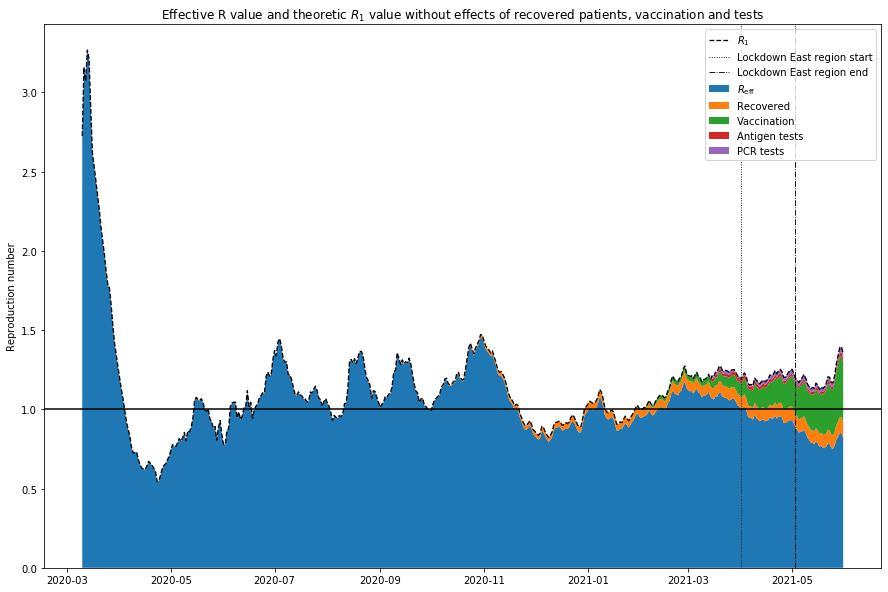

In [13]:
plot_r_decompositon(r_eff, recovered, vaccinations, tests_antigen, tests_pcr)
plt.legend(loc='upper right');

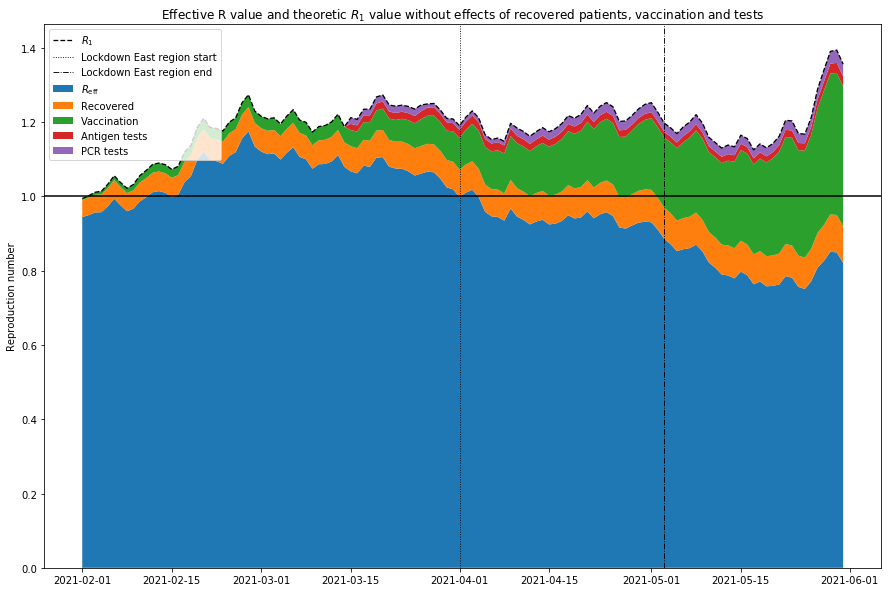

In [14]:
plot_r_decompositon(r_eff.loc['2021-02-01':], recovered, vaccinations, tests_antigen, tests_pcr)

## Future scenarios

In [15]:
def extrapolate_linearely(timeseries, end, interpolation_range_days=20):
    rate = (timeseries.iloc[-1] - vaccinations.iloc[-interpolation_range_days])/interpolation_range_days
    future_range = pd.date_range(timeseries.index[-1], end=end, closed='right')
    timeseries_future = pd.Series(np.arange(timeseries.iloc[-1] + rate,
                                            timeseries.iloc[-1] + len(future_range) * rate + 1,
                                            step=rate),
                                  index=future_range)
    return timeseries.append(timeseries_future)

def extrapolate_constant(timeseries, end, constant=None):
    future_range = pd.date_range(timeseries.index[-1], end=end, closed='right')
    if constant is None:
        constant = timeseries.iloc[-1]
    timeseries_future = pd.Series(np.ones(len(future_range)) * constant,
                                  index=future_range)
    return timeseries.append(timeseries_future)

def plot_r_decompositon_projection(r_eff, recovered, vaccinations, tests_antigen, tests_pcr,
                                   projection_start, r1_extrapolation=None):
    plot_r_decompositon(r_eff.loc[:projection_start],
                        recovered.loc[:projection_start],
                        vaccinations.loc[:projection_start],
                        tests_antigen.loc[:projection_start],
                        tests_pcr.loc[:projection_start])

    plt.gca().set_prop_cycle(None)

    plot_r_decompositon(r_eff, recovered, vaccinations, tests_antigen, tests_pcr, projection=True,
                        projection_start=projection_start, r1_extrapolation=r1_extrapolation)


### Good scenario

This is not the best case scenario, but still a good scenario. If we assume that numbers of new cases are low enough and we can manage to keep $R_\mathrm{eff} \leq 1$, everything should be more or less fine. How large can $R_1$ get, i.e. can we really go back to old normal life and if so when? We can compare the $R_1$ in this scenario to the $R_1$ value of last summer for example or multiply it with 150% for the mutation B.1.1.7 or with 200% for the mutation B.1.617. If we assume that there was an $R_1$

In [16]:
PROJECTION_LENGTH_DAYS = 40

# note that not all time series end at the same day, r_eff is usally shorter
projection_start = min((x.index[-1] for x in (r_eff, recovered, vaccinations, tests_antigen, tests_pcr)))
projection_end = projection_start + pd.DateOffset(PROJECTION_LENGTH_DAYS)

In [17]:
r_eff_projection = extrapolate_constant(r_eff.loc['2021-02-01':], projection_end, 1)
recovered_projection = extrapolate_constant(cases_cum, projection_end)
vaccinations_projection = extrapolate_linearely(vaccinations, projection_end)
tests_antigen_projection = extrapolate_constant(tests_antigen, projection_end)
tests_pcr_projection = extrapolate_constant(tests_pcr, projection_end)

R1=1.666625059046293 at start start of projection


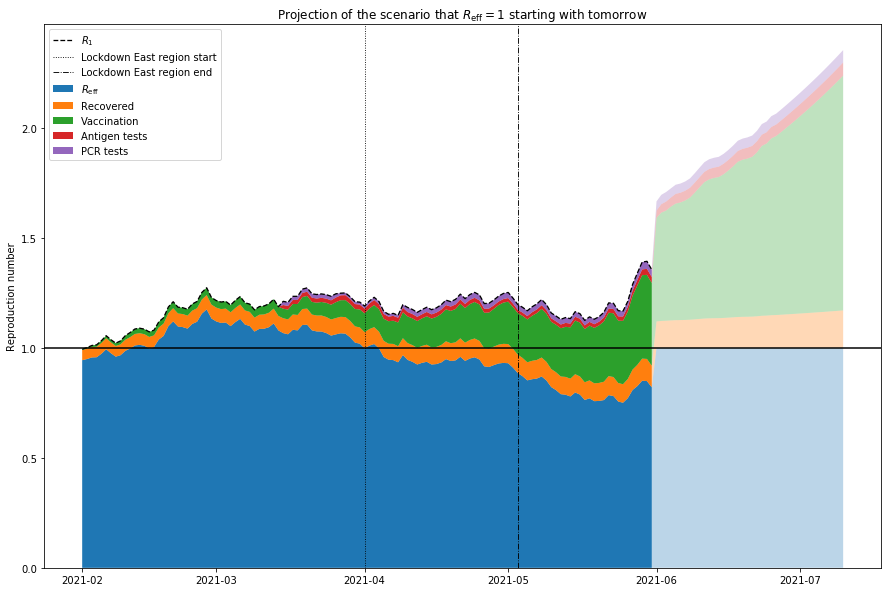

In [18]:
plot_r_decompositon_projection(r_eff_projection, recovered_projection, vaccinations_projection,
                               tests_antigen_projection, tests_pcr_projection, projection_start)
plt.title('Projection of the scenario that $R_\mathrm{eff}=1$ starting with tomorrow');

### Worst case scenario

Even if we go the other way around and assume a worst case scenaro, that $R_1$ is around 1.3 as last summer but with a 200% increase due to the mutation, we see that $R_\mathrm{eff}$ will drop again rather soon.

In [19]:
MAX_R1 = 1.3 * 2

In [20]:
r_eff_projection = extrapolate_constant(r_eff.loc['2021-02-01':], projection_end, 1)
recovered_projection = extrapolate_constant(cases_cum, projection_end)
vaccinations_projection = extrapolate_linearely(vaccinations, projection_end)
tests_antigen_projection = extrapolate_constant(tests_antigen, projection_end)
tests_pcr_projection = extrapolate_constant(tests_pcr, projection_end)

In [21]:
PROJECTION_LENGTH_DAYS = 70

# note that not all time series end at the same day, r_eff is usally shorter
projection_start = min((x.index[-1] for x in (r_eff, recovered, vaccinations, tests_antigen, tests_pcr)))
projection_end = projection_start + pd.DateOffset(PROJECTION_LENGTH_DAYS)

In [22]:
r_eff_projection = extrapolate_constant(r_eff.loc['2021-02-01':], projection_end, 1)
recovered_projection = extrapolate_constant(cases_cum, projection_end)
vaccinations_projection = extrapolate_linearely(vaccinations, projection_end)
tests_antigen_projection = extrapolate_constant(tests_antigen, projection_end)
tests_pcr_projection = extrapolate_constant(tests_pcr, projection_end)

R1=2.6 at start start of projection


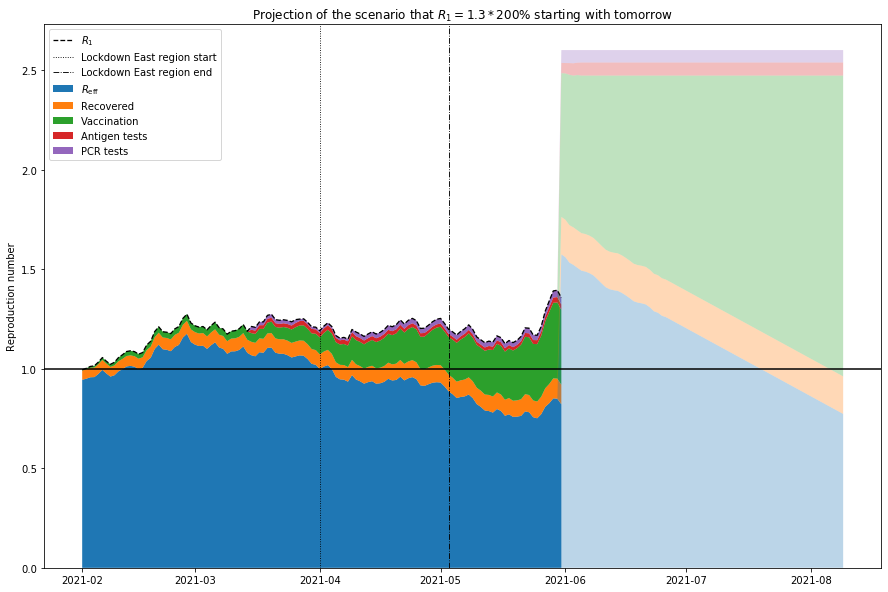

In [23]:
plot_r_decompositon_projection(r_eff_projection, recovered_projection, vaccinations_projection,
                               tests_antigen_projection, tests_pcr_projection, projection_start, r1_extrapolation=MAX_R1)
plt.title('Projection of the scenario that $R_1= 1.3 * 200\%$ starting with tomorrow');

## How many additional infections?

If we assume a steady decline of $R_\mathrm{eff}$ from 1.6 to 1 for 75 days, more than 10 thousand people are expected to get infected. But if we assume that $R_\mathrm{eff}$ drops from 1.7 to 1 in 90 days, 75 thousand people will get infected. This computation is highly sensitive to the parameters.

In [24]:
CASES_NOW_PER_100K = 30
DAYS_PER_TRANSMISSION = 4.5
DAYS = 75

CASES_NOW_PER_100K * np.linspace(1.6, 1, num=int(DAYS/DAYS_PER_TRANSMISSION)).cumprod().sum()

12841.491301845073

In [25]:
CASES_NOW_PER_100K = 30
DAYS_PER_TRANSMISSION = 4.5
DAYS = 90

CASES_NOW_PER_100K * np.linspace(1.7, 1, num=int(DAYS/DAYS_PER_TRANSMISSION)).cumprod().sum()

74152.43481172418

## Analysis of vaccinations

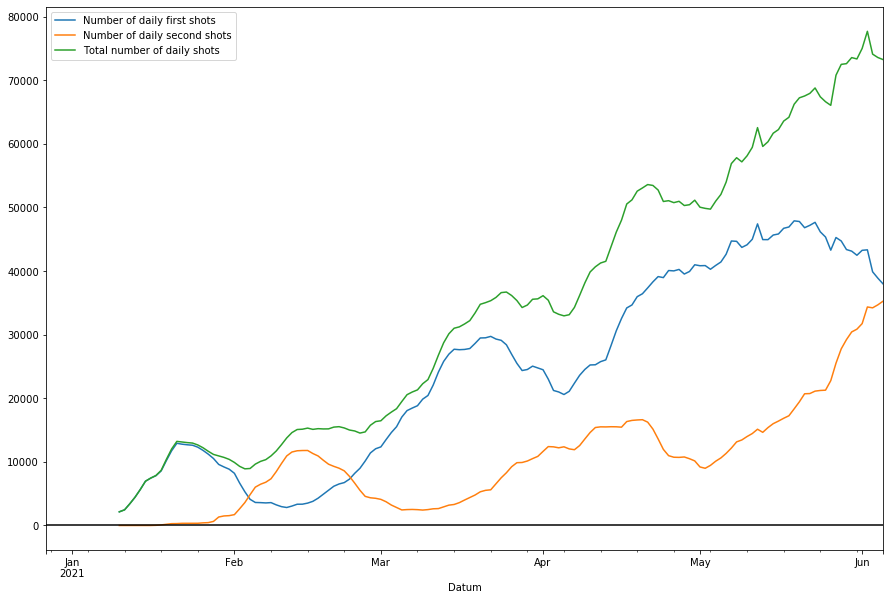

In [26]:
# Note: the Johnson & Johnson is counted as second shot

first_shots = vaccinations.diff()
second_shots = vaccinations_at.Vollimmunisierte.diff()

first_shots_filtered = vaccinations.rolling(14).mean().diff()
second_shots_filted = vaccinations_at.Vollimmunisierte.rolling(14).mean().diff()

first_shots_filtered.plot.line(label='Number of daily first shots', legend=True)
second_shots_filted.plot(label='Number of daily second shots', legend=True)
(first_shots_filtered + second_shots_filted).plot(label='Total number of daily shots', legend=True)

plt.axhline(color='k');

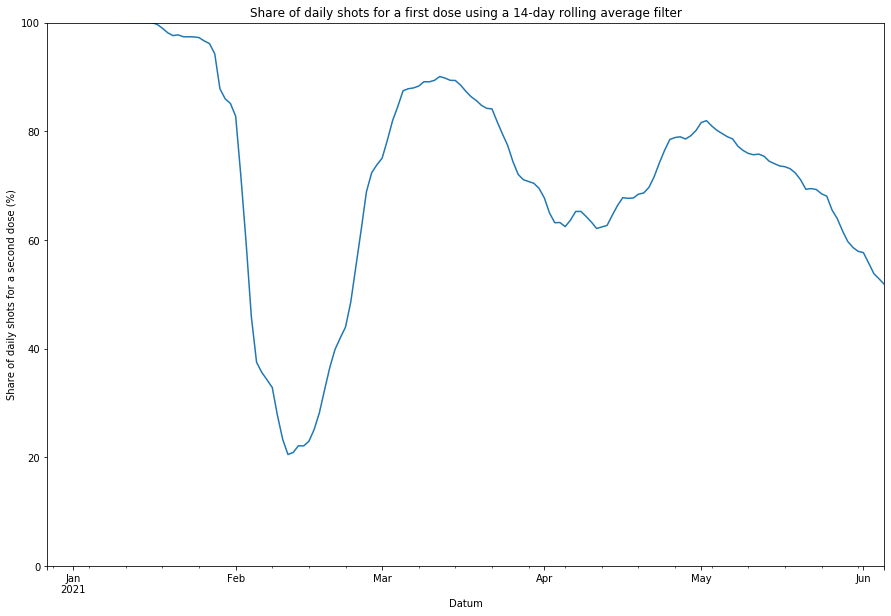

In [27]:
(100 * first_shots_filtered / (first_shots_filtered + second_shots_filted)).plot.line('-k')
plt.ylim(0, 100)
plt.title('Share of daily shots for a first dose using a 14-day rolling average filter')
plt.ylabel('Share of daily shots for a second dose (%)');

## How many people can't get the vaccination?

In [28]:
inoculable = 3879546 / (49.28/100)  # from https://info.gesundheitsministerium.at/
inoculable / vaccinations_at.Bevölkerung.iloc[-1]

0.8844398104701705

## Poor-man unit tests

In [29]:
for timeseries in (tests_antigen, vaccinations, cases_cum, r_eff):
    assert np.all(np.diff(timeseries.index).astype(np.int) == 60 * 60 * 24 * 1e9)

In [30]:
# just a simple plausibility test
assert np.all(vaccinations > vaccinations_at.Vollimmunisierte)